In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [ ]:
!wget https://onti2020.ai-academy.ru/task/rucos_val.jsonl
!wget https://onti2020.ai-academy.ru/task/rucos_test.jsonl
!wget https://onti2020.ai-academy.ru/task/rucos_train.jsonl.zip
!unzip rucos_train.jsonl.zip -d ./

!rm rucos_train.jsonl.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
import json
import re
from tqdm.notebook import tqdm

FEATURES_COUNT = 190

def clean_text(text):

    text = text.lower()
    
    pattern = '\(\d+\)'
    text = re.sub(pattern, '', text)

    text = text.replace('\xad', ' ')
    text = text.replace('\u00ad', ' ')
    text = text.replace('\N{SOFT HYPHEN}', ' ')
    text = text.replace("\n@highlight\n", ' ')
    text = text.replace("\n@placeholder\n", ' ')

    text = text.replace('«', ' ')
    text = text.replace('»', ' ')  
    text = text.replace('...', ' ') 
    text = text.replace('—', ' ') 

    text = re.sub(r'[^\w\s]','',text)

    return text

def text_splitter(text, amount=FEATURES_COUNT): 
    tokens = clean_text(text).split(' ')
    new_text = ' '.join(tokens[-amount:])
    return new_text

def get_X_y_for_bert(data_json_file):
    X, y = [], []
    with open(data_json_file, 'r', encoding='utf8') as json_file:
        json_list = list(json_file)
        for json_str in tqdm(json_list):
            item = json.loads(json_str)
            text = item['passage']['text']
            query = item['qas'][0]['query']
            ans = item['passage']['entities']

            right_answers = []
            for elem in item['qas'][0]['answers']:
                right_answers.append(elem['text'])

            for a in ans:
                X.append('[CLS] '+ (text_splitter(query+' '+ ' textquestionseparator '+text)).replace('textquestionseparator', '[SEP]').replace('placeholder', item['passage']['text'][a['start']:a['end']]))
                y.append(1 if item['passage']['text'][a['start']:a['end']] in right_answers else 0)
    return X, y

def get_X(data_json_file):
    X = []
    with open(data_json_file, 'r', encoding='utf8') as json_file:
        json_list = list(json_file)
        for json_str in tqdm(json_list):
            item = json.loads(json_str)
            text = item['passage']['text']
            query = item['qas'][0]['query']
            ans = item['passage']['entities']
            for a in ans:
                X.append('[CLS] '+ (text_splitter(query+' '+ ' textquestionseparator '+text)).replace('textquestionseparator', '[SEP]').replace('placeholder', item['passage']['text'][a['start']:a['end']]))
                
    return X

In [ ]:
X_train, y_train = get_X_y_for_bert('rucos_train.jsonl')
X_valid, y_valid = get_X_y_for_bert('rucos_val.jsonl')
X_test = get_X('rucos_test.jsonl') 

In [ ]:
print(len(X_train), len(X_valid), len(X_test))

918625 108749 96996


In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

MODEL_NAME = "bert-base-multilingual-cased"

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', X_train[100])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X_train[100]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train[100])))

 Original:  [CLS] разговаривала с журналистами с позиции силы но теперь с журналистами будут вести переговоры еще меньше а больше будут пытаться воздействовать силовым нажимом  отметил касютин  [SEP] инциденты с радиостанцией эхо москвы и телеканалом дождь стали поводом говорить о попытках власти оказать давление на прессу накануне президентских выборов в россии эксперты считают что пора бить тревогу последние события происходящие вокруг российских сми в частности изменения в руководстве радиостанции эхо москвы которые на этой неделе инициировал главный акционер  холдинг газпроммедиа дали повод для разговоров о попытках власти задушить оппозиционные сми в россии связанные одной цепью
президент фонда защиты гласности член совета при президенте россии по содействию развитию гражданского общества и правам человека алексей симонов видит взаимосвязь событий происходящих в сми в большинстве конфликтов одной из сторон выступал холдинг газпроммедиа и все они происходили незадолго до или сразу 

In [ ]:
def tokenize_texts(sentences):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in tqdm(sentences):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          #pad_to_max_length = True,
                          padding='max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids, attention_masks

In [ ]:
X_train, X_train_masks = tokenize_texts(X_train)
X_valid, X_valid_masks = tokenize_texts(X_valid)


Original:  [CLS] кроме того серьезным вызовом для россии становится стремительно развивающийся китайеще в понедельник Домодедово в рамках спора о системе противоракетной обороны пригрозил размещением дополнительных ракетных комплексов  [SEP] наблюдатели полагают что подоплекой теракта в домодедово является провал кавказской политики российского правительства указывает немецкая печать немецкая печать продолжает комментировать теракт в домодедово так газета süddeutsche zeitung пишет
ну конечно же после взрыва в домодедово вновь обнаруживается кавказский след его обнаруживают почти всегда когда в россии взрывается бомба в метро в поезде или на рынке и неважно что очевидцы нередко не в состоянии сказать был ли преступник женщиной в чадре или же мужчиной грозившим всех уничтожитьсреди жертв взрыва в домодедово есть граждане германии великобритании австрии ежедневно в москве совершают посадку более 3 десятков самолетов из германии немецкий менеджер аэропорта домодедово отвергает обвинения м


Original:  [CLS] в него вошли ООН россия украина и франция  [SEP] главной темой переговоров наряду с прежними спорными вопросами такими как отвод тяжелых вооружений и сохранение перемирия станет организация миротворческой миссии оон для донбасса header инициатива главы германского мида
с инициативой собрать глав внешнеполитических ведомств стран нормандского формата в берлине выступил министр иностранных дел германии хайко мас heiko maas во время своего визита в украину находясь в мариуполе куда он приехал чтобы составить собственное впечатление о ситуации на востоке украины мас выразил надежду что на встрече которая пройдет после 15месячного перерыва удастся вдохнуть новую жизнь в процесс урегулирования войны в донбассе путин говорит порусски на переговорах в нормандском формате чтобы показать силу на самом же деле он демонстрирует одиночество в этой четверке считает политолог иван преображенский 
по словам маса главной темой переговоров наряду с прежними спорными вопросами такими ка

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train, X_train_masks, torch.tensor(y_train))
val_dataset = TensorDataset(X_valid, X_valid_masks, torch.tensor(y_valid))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    #"bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    MODEL_NAME,
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  #lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        # loss, logits = model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)
        output = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        loss = output.loss
        logits = output.logits


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.

            # (loss, logits) = model(b_input_ids, 
            #                        token_type_ids=None, 
            #                        attention_mask=b_input_mask,
            #                        labels=b_labels)
            output = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  114,829.    Elapsed: 0:00:18.
  Batch    80  of  114,829.    Elapsed: 0:00:37.
  Batch   120  of  114,829.    Elapsed: 0:00:55.
  Batch   160  of  114,829.    Elapsed: 0:01:13.
  Batch   200  of  114,829.    Elapsed: 0:01:31.
  Batch   240  of  114,829.    Elapsed: 0:01:49.
  Batch   280  of  114,829.    Elapsed: 0:02:07.
  Batch   320  of  114,829.    Elapsed: 0:02:26.
  Batch   360  of  114,829.    Elapsed: 0:02:44.
  Batch   400  of  114,829.    Elapsed: 0:03:02.
  Batch   440  of  114,829.    Elapsed: 0:03:21.
  Batch   480  of  114,829.    Elapsed: 0:03:39.
  Batch   520  of  114,829.    Elapsed: 0:03:57.
  Batch   560  of  114,829.    Elapsed: 0:04:16.
  Batch   600  of  114,829.    Elapsed: 0:04:34.
  Batch   640  of  114,829.    Elapsed: 0:04:52.
  Batch   680  of  114,829.    Elapsed: 0:05:11.
  Batch   720  of  114,829.    Elapsed: 0:05:29.
  Batch   760  of  114,829.    Elapsed: 0:05:47.
  Batch   800  of  114,829

  Batch 6,720  of  114,829.    Elapsed: 0:51:22.
  Batch 6,760  of  114,829.    Elapsed: 0:51:40.
  Batch 6,800  of  114,829.    Elapsed: 0:51:58.
  Batch 6,840  of  114,829.    Elapsed: 0:52:17.
  Batch 6,880  of  114,829.    Elapsed: 0:52:35.
  Batch 6,920  of  114,829.    Elapsed: 0:52:53.
  Batch 6,960  of  114,829.    Elapsed: 0:53:12.
  Batch 7,000  of  114,829.    Elapsed: 0:53:30.
  Batch 7,040  of  114,829.    Elapsed: 0:53:48.
  Batch 7,080  of  114,829.    Elapsed: 0:54:07.
  Batch 7,120  of  114,829.    Elapsed: 0:54:25.
  Batch 7,160  of  114,829.    Elapsed: 0:54:44.
  Batch 7,200  of  114,829.    Elapsed: 0:55:02.
  Batch 7,240  of  114,829.    Elapsed: 0:55:20.
  Batch 7,280  of  114,829.    Elapsed: 0:55:39.
  Batch 7,320  of  114,829.    Elapsed: 0:55:57.
  Batch 7,360  of  114,829.    Elapsed: 0:56:16.
  Batch 7,400  of  114,829.    Elapsed: 0:56:34.
  Batch 7,440  of  114,829.    Elapsed: 0:56:52.
  Batch 7,480  of  114,829.    Elapsed: 0:57:11.
  Batch 7,520  of  1

  Batch 13,360  of  114,829.    Elapsed: 1:42:13.
  Batch 13,400  of  114,829.    Elapsed: 1:42:31.
  Batch 13,440  of  114,829.    Elapsed: 1:42:50.
  Batch 13,480  of  114,829.    Elapsed: 1:43:08.
  Batch 13,520  of  114,829.    Elapsed: 1:43:26.
  Batch 13,560  of  114,829.    Elapsed: 1:43:45.
  Batch 13,600  of  114,829.    Elapsed: 1:44:03.
  Batch 13,640  of  114,829.    Elapsed: 1:44:21.
  Batch 13,680  of  114,829.    Elapsed: 1:44:40.
  Batch 13,720  of  114,829.    Elapsed: 1:44:58.
  Batch 13,760  of  114,829.    Elapsed: 1:45:17.
  Batch 13,800  of  114,829.    Elapsed: 1:45:35.
  Batch 13,840  of  114,829.    Elapsed: 1:45:53.
  Batch 13,880  of  114,829.    Elapsed: 1:46:12.
  Batch 13,920  of  114,829.    Elapsed: 1:46:30.
  Batch 13,960  of  114,829.    Elapsed: 1:46:49.
  Batch 14,000  of  114,829.    Elapsed: 1:47:07.
  Batch 14,040  of  114,829.    Elapsed: 1:47:25.
  Batch 14,080  of  114,829.    Elapsed: 1:47:44.
  Batch 14,120  of  114,829.    Elapsed: 1:48:02.


  Batch 19,920  of  114,829.    Elapsed: 2:32:27.
  Batch 19,960  of  114,829.    Elapsed: 2:32:46.
  Batch 20,000  of  114,829.    Elapsed: 2:33:04.
  Batch 20,040  of  114,829.    Elapsed: 2:33:23.
  Batch 20,080  of  114,829.    Elapsed: 2:33:41.
  Batch 20,120  of  114,829.    Elapsed: 2:33:59.
  Batch 20,160  of  114,829.    Elapsed: 2:34:18.
  Batch 20,200  of  114,829.    Elapsed: 2:34:36.
  Batch 20,240  of  114,829.    Elapsed: 2:34:54.
  Batch 20,280  of  114,829.    Elapsed: 2:35:13.
  Batch 20,320  of  114,829.    Elapsed: 2:35:31.
  Batch 20,360  of  114,829.    Elapsed: 2:35:50.
  Batch 20,400  of  114,829.    Elapsed: 2:36:08.
  Batch 20,440  of  114,829.    Elapsed: 2:36:26.
  Batch 20,480  of  114,829.    Elapsed: 2:36:45.
  Batch 20,520  of  114,829.    Elapsed: 2:37:03.
  Batch 20,560  of  114,829.    Elapsed: 2:37:22.
  Batch 20,600  of  114,829.    Elapsed: 2:37:40.
  Batch 20,640  of  114,829.    Elapsed: 2:37:58.
  Batch 20,680  of  114,829.    Elapsed: 2:38:17.


  Batch 26,480  of  114,829.    Elapsed: 3:22:42.
  Batch 26,520  of  114,829.    Elapsed: 3:23:00.
  Batch 26,560  of  114,829.    Elapsed: 3:23:19.
  Batch 26,600  of  114,829.    Elapsed: 3:23:37.
  Batch 26,640  of  114,829.    Elapsed: 3:23:56.
  Batch 26,680  of  114,829.    Elapsed: 3:24:14.
  Batch 26,720  of  114,829.    Elapsed: 3:24:32.
  Batch 26,760  of  114,829.    Elapsed: 3:24:51.
  Batch 26,800  of  114,829.    Elapsed: 3:25:09.
  Batch 26,840  of  114,829.    Elapsed: 3:25:28.
  Batch 26,880  of  114,829.    Elapsed: 3:25:46.
  Batch 26,920  of  114,829.    Elapsed: 3:26:04.
  Batch 26,960  of  114,829.    Elapsed: 3:26:23.
  Batch 27,000  of  114,829.    Elapsed: 3:26:41.
  Batch 27,040  of  114,829.    Elapsed: 3:27:00.
  Batch 27,080  of  114,829.    Elapsed: 3:27:18.
  Batch 27,120  of  114,829.    Elapsed: 3:27:36.
  Batch 27,160  of  114,829.    Elapsed: 3:27:55.
  Batch 27,200  of  114,829.    Elapsed: 3:28:13.
  Batch 27,240  of  114,829.    Elapsed: 3:28:32.


  Batch 33,040  of  114,829.    Elapsed: 4:12:56.
  Batch 33,080  of  114,829.    Elapsed: 4:13:15.
  Batch 33,120  of  114,829.    Elapsed: 4:13:33.
  Batch 33,160  of  114,829.    Elapsed: 4:13:51.
  Batch 33,200  of  114,829.    Elapsed: 4:14:10.
  Batch 33,240  of  114,829.    Elapsed: 4:14:28.
  Batch 33,280  of  114,829.    Elapsed: 4:14:46.
  Batch 33,320  of  114,829.    Elapsed: 4:15:05.
  Batch 33,360  of  114,829.    Elapsed: 4:15:23.
  Batch 33,400  of  114,829.    Elapsed: 4:15:41.
  Batch 33,440  of  114,829.    Elapsed: 4:16:00.
  Batch 33,480  of  114,829.    Elapsed: 4:16:18.
  Batch 33,520  of  114,829.    Elapsed: 4:16:37.
  Batch 33,560  of  114,829.    Elapsed: 4:16:55.
  Batch 33,600  of  114,829.    Elapsed: 4:17:13.
  Batch 33,640  of  114,829.    Elapsed: 4:17:32.
  Batch 33,680  of  114,829.    Elapsed: 4:17:50.
  Batch 33,720  of  114,829.    Elapsed: 4:18:08.
  Batch 33,760  of  114,829.    Elapsed: 4:18:27.
  Batch 33,800  of  114,829.    Elapsed: 4:18:45.


  Batch 39,600  of  114,829.    Elapsed: 5:03:13.
  Batch 39,640  of  114,829.    Elapsed: 5:03:31.
  Batch 39,680  of  114,829.    Elapsed: 5:03:49.
  Batch 39,720  of  114,829.    Elapsed: 5:04:08.
  Batch 39,760  of  114,829.    Elapsed: 5:04:26.
  Batch 39,800  of  114,829.    Elapsed: 5:04:44.
  Batch 39,840  of  114,829.    Elapsed: 5:05:03.
  Batch 39,880  of  114,829.    Elapsed: 5:05:21.
  Batch 39,920  of  114,829.    Elapsed: 5:05:40.
  Batch 39,960  of  114,829.    Elapsed: 5:05:58.
  Batch 40,000  of  114,829.    Elapsed: 5:06:16.
  Batch 40,040  of  114,829.    Elapsed: 5:06:35.
  Batch 40,080  of  114,829.    Elapsed: 5:06:53.
  Batch 40,120  of  114,829.    Elapsed: 5:07:11.
  Batch 40,160  of  114,829.    Elapsed: 5:07:30.
  Batch 40,200  of  114,829.    Elapsed: 5:07:48.
  Batch 40,240  of  114,829.    Elapsed: 5:08:06.
  Batch 40,280  of  114,829.    Elapsed: 5:08:25.
  Batch 40,320  of  114,829.    Elapsed: 5:08:43.
  Batch 40,360  of  114,829.    Elapsed: 5:09:02.


  Batch 46,160  of  114,829.    Elapsed: 5:53:28.
  Batch 46,200  of  114,829.    Elapsed: 5:53:46.
  Batch 46,240  of  114,829.    Elapsed: 5:54:05.
  Batch 46,280  of  114,829.    Elapsed: 5:54:23.
  Batch 46,320  of  114,829.    Elapsed: 5:54:42.
  Batch 46,360  of  114,829.    Elapsed: 5:55:00.
  Batch 46,400  of  114,829.    Elapsed: 5:55:18.
  Batch 46,440  of  114,829.    Elapsed: 5:55:37.
  Batch 46,480  of  114,829.    Elapsed: 5:55:55.
  Batch 46,520  of  114,829.    Elapsed: 5:56:13.
  Batch 46,560  of  114,829.    Elapsed: 5:56:32.
  Batch 46,600  of  114,829.    Elapsed: 5:56:50.
  Batch 46,640  of  114,829.    Elapsed: 5:57:08.
  Batch 46,680  of  114,829.    Elapsed: 5:57:27.
  Batch 46,720  of  114,829.    Elapsed: 5:57:45.
  Batch 46,760  of  114,829.    Elapsed: 5:58:03.
  Batch 46,800  of  114,829.    Elapsed: 5:58:22.
  Batch 46,840  of  114,829.    Elapsed: 5:58:40.
  Batch 46,880  of  114,829.    Elapsed: 5:58:59.
  Batch 46,920  of  114,829.    Elapsed: 5:59:17.


  Batch 52,720  of  114,829.    Elapsed: 6:43:39.
  Batch 52,760  of  114,829.    Elapsed: 6:43:58.
  Batch 52,800  of  114,829.    Elapsed: 6:44:16.
  Batch 52,840  of  114,829.    Elapsed: 6:44:34.
  Batch 52,880  of  114,829.    Elapsed: 6:44:53.
  Batch 52,920  of  114,829.    Elapsed: 6:45:11.
  Batch 52,960  of  114,829.    Elapsed: 6:45:30.
  Batch 53,000  of  114,829.    Elapsed: 6:45:48.
  Batch 53,040  of  114,829.    Elapsed: 6:46:06.
  Batch 53,080  of  114,829.    Elapsed: 6:46:25.
  Batch 53,120  of  114,829.    Elapsed: 6:46:43.
  Batch 53,160  of  114,829.    Elapsed: 6:47:01.
  Batch 53,200  of  114,829.    Elapsed: 6:47:20.
  Batch 53,240  of  114,829.    Elapsed: 6:47:38.
  Batch 53,280  of  114,829.    Elapsed: 6:47:56.
  Batch 53,320  of  114,829.    Elapsed: 6:48:15.
  Batch 53,360  of  114,829.    Elapsed: 6:48:33.
  Batch 53,400  of  114,829.    Elapsed: 6:48:52.
  Batch 53,440  of  114,829.    Elapsed: 6:49:10.
  Batch 53,480  of  114,829.    Elapsed: 6:49:28.


  Batch 59,280  of  114,829.    Elapsed: 7:33:51.
  Batch 59,320  of  114,829.    Elapsed: 7:34:09.
  Batch 59,360  of  114,829.    Elapsed: 7:34:27.
  Batch 59,400  of  114,829.    Elapsed: 7:34:46.
  Batch 59,440  of  114,829.    Elapsed: 7:35:04.
  Batch 59,480  of  114,829.    Elapsed: 7:35:22.
  Batch 59,520  of  114,829.    Elapsed: 7:35:41.
  Batch 59,560  of  114,829.    Elapsed: 7:35:59.
  Batch 59,600  of  114,829.    Elapsed: 7:36:17.
  Batch 59,640  of  114,829.    Elapsed: 7:36:36.
  Batch 59,680  of  114,829.    Elapsed: 7:36:54.
  Batch 59,720  of  114,829.    Elapsed: 7:37:12.
  Batch 59,760  of  114,829.    Elapsed: 7:37:31.
  Batch 59,800  of  114,829.    Elapsed: 7:37:49.
  Batch 59,840  of  114,829.    Elapsed: 7:38:07.
  Batch 59,880  of  114,829.    Elapsed: 7:38:26.
  Batch 59,920  of  114,829.    Elapsed: 7:38:44.
  Batch 59,960  of  114,829.    Elapsed: 7:39:02.
  Batch 60,000  of  114,829.    Elapsed: 7:39:21.
  Batch 60,040  of  114,829.    Elapsed: 7:39:39.


  Batch 65,840  of  114,829.    Elapsed: 8:24:03.
  Batch 65,880  of  114,829.    Elapsed: 8:24:22.
  Batch 65,920  of  114,829.    Elapsed: 8:24:40.
  Batch 65,960  of  114,829.    Elapsed: 8:24:58.
  Batch 66,000  of  114,829.    Elapsed: 8:25:17.
  Batch 66,040  of  114,829.    Elapsed: 8:25:35.
  Batch 66,080  of  114,829.    Elapsed: 8:25:54.
  Batch 66,120  of  114,829.    Elapsed: 8:26:12.
  Batch 66,160  of  114,829.    Elapsed: 8:26:30.
  Batch 66,200  of  114,829.    Elapsed: 8:26:49.
  Batch 66,240  of  114,829.    Elapsed: 8:27:07.
  Batch 66,280  of  114,829.    Elapsed: 8:27:25.
  Batch 66,320  of  114,829.    Elapsed: 8:27:44.
  Batch 66,360  of  114,829.    Elapsed: 8:28:02.
  Batch 66,400  of  114,829.    Elapsed: 8:28:20.
  Batch 66,440  of  114,829.    Elapsed: 8:28:39.
  Batch 66,480  of  114,829.    Elapsed: 8:28:57.
  Batch 66,520  of  114,829.    Elapsed: 8:29:15.
  Batch 66,560  of  114,829.    Elapsed: 8:29:34.
  Batch 66,600  of  114,829.    Elapsed: 8:29:52.


  Batch 72,400  of  114,829.    Elapsed: 9:14:15.
  Batch 72,440  of  114,829.    Elapsed: 9:14:33.
  Batch 72,480  of  114,829.    Elapsed: 9:14:52.
  Batch 72,520  of  114,829.    Elapsed: 9:15:10.
  Batch 72,560  of  114,829.    Elapsed: 9:15:29.
  Batch 72,600  of  114,829.    Elapsed: 9:15:47.
  Batch 72,640  of  114,829.    Elapsed: 9:16:05.
  Batch 72,680  of  114,829.    Elapsed: 9:16:24.
  Batch 72,720  of  114,829.    Elapsed: 9:16:42.
  Batch 72,760  of  114,829.    Elapsed: 9:17:01.
  Batch 72,800  of  114,829.    Elapsed: 9:17:19.
  Batch 72,840  of  114,829.    Elapsed: 9:17:37.
  Batch 72,880  of  114,829.    Elapsed: 9:17:56.
  Batch 72,920  of  114,829.    Elapsed: 9:18:14.
  Batch 72,960  of  114,829.    Elapsed: 9:18:32.
  Batch 73,000  of  114,829.    Elapsed: 9:18:51.
  Batch 73,040  of  114,829.    Elapsed: 9:19:09.
  Batch 73,080  of  114,829.    Elapsed: 9:19:28.
  Batch 73,120  of  114,829.    Elapsed: 9:19:46.
  Batch 73,160  of  114,829.    Elapsed: 9:20:04.


  Batch 78,960  of  114,829.    Elapsed: 10:04:29.
  Batch 79,000  of  114,829.    Elapsed: 10:04:48.
  Batch 79,040  of  114,829.    Elapsed: 10:05:06.
  Batch 79,080  of  114,829.    Elapsed: 10:05:24.
  Batch 79,120  of  114,829.    Elapsed: 10:05:43.
  Batch 79,160  of  114,829.    Elapsed: 10:06:01.
  Batch 79,200  of  114,829.    Elapsed: 10:06:19.
  Batch 79,240  of  114,829.    Elapsed: 10:06:38.
  Batch 79,280  of  114,829.    Elapsed: 10:06:56.
  Batch 79,320  of  114,829.    Elapsed: 10:07:15.
  Batch 79,360  of  114,829.    Elapsed: 10:07:33.
  Batch 79,400  of  114,829.    Elapsed: 10:07:51.
  Batch 79,440  of  114,829.    Elapsed: 10:08:10.
  Batch 79,480  of  114,829.    Elapsed: 10:08:28.
  Batch 79,520  of  114,829.    Elapsed: 10:08:47.
  Batch 79,560  of  114,829.    Elapsed: 10:09:05.
  Batch 79,600  of  114,829.    Elapsed: 10:09:23.
  Batch 79,640  of  114,829.    Elapsed: 10:09:42.
  Batch 79,680  of  114,829.    Elapsed: 10:10:00.
  Batch 79,720  of  114,829.   

  Batch 85,400  of  114,829.    Elapsed: 10:53:47.
  Batch 85,440  of  114,829.    Elapsed: 10:54:06.
  Batch 85,480  of  114,829.    Elapsed: 10:54:24.
  Batch 85,520  of  114,829.    Elapsed: 10:54:42.
  Batch 85,560  of  114,829.    Elapsed: 10:55:01.
  Batch 85,600  of  114,829.    Elapsed: 10:55:19.
  Batch 85,640  of  114,829.    Elapsed: 10:55:38.
  Batch 85,680  of  114,829.    Elapsed: 10:55:56.
  Batch 85,720  of  114,829.    Elapsed: 10:56:14.
  Batch 85,760  of  114,829.    Elapsed: 10:56:33.
  Batch 85,800  of  114,829.    Elapsed: 10:56:51.
  Batch 85,840  of  114,829.    Elapsed: 10:57:09.
  Batch 85,880  of  114,829.    Elapsed: 10:57:28.
  Batch 85,920  of  114,829.    Elapsed: 10:57:46.
  Batch 85,960  of  114,829.    Elapsed: 10:58:04.
  Batch 86,000  of  114,829.    Elapsed: 10:58:23.
  Batch 86,040  of  114,829.    Elapsed: 10:58:41.
  Batch 86,080  of  114,829.    Elapsed: 10:59:00.
  Batch 86,120  of  114,829.    Elapsed: 10:59:18.
  Batch 86,160  of  114,829.   

  Batch 91,840  of  114,829.    Elapsed: 11:43:10.
  Batch 91,880  of  114,829.    Elapsed: 11:43:28.
  Batch 91,920  of  114,829.    Elapsed: 11:43:46.
  Batch 91,960  of  114,829.    Elapsed: 11:44:05.
  Batch 92,000  of  114,829.    Elapsed: 11:44:23.
  Batch 92,040  of  114,829.    Elapsed: 11:44:42.
  Batch 92,080  of  114,829.    Elapsed: 11:45:00.
  Batch 92,120  of  114,829.    Elapsed: 11:45:18.
  Batch 92,160  of  114,829.    Elapsed: 11:45:37.
  Batch 92,200  of  114,829.    Elapsed: 11:45:55.
  Batch 92,240  of  114,829.    Elapsed: 11:46:14.
  Batch 92,280  of  114,829.    Elapsed: 11:46:32.
  Batch 92,320  of  114,829.    Elapsed: 11:46:51.
  Batch 92,360  of  114,829.    Elapsed: 11:47:09.
  Batch 92,400  of  114,829.    Elapsed: 11:47:27.
  Batch 92,440  of  114,829.    Elapsed: 11:47:46.
  Batch 92,480  of  114,829.    Elapsed: 11:48:04.
  Batch 92,520  of  114,829.    Elapsed: 11:48:23.
  Batch 92,560  of  114,829.    Elapsed: 11:48:41.
  Batch 92,600  of  114,829.   

  Batch 98,280  of  114,829.    Elapsed: 12:32:47.
  Batch 98,320  of  114,829.    Elapsed: 12:33:05.
  Batch 98,360  of  114,829.    Elapsed: 12:33:24.
  Batch 98,400  of  114,829.    Elapsed: 12:33:42.
  Batch 98,440  of  114,829.    Elapsed: 12:34:01.
  Batch 98,480  of  114,829.    Elapsed: 12:34:20.
  Batch 98,520  of  114,829.    Elapsed: 12:34:38.
  Batch 98,560  of  114,829.    Elapsed: 12:34:57.
  Batch 98,600  of  114,829.    Elapsed: 12:35:15.
  Batch 98,640  of  114,829.    Elapsed: 12:35:34.
  Batch 98,680  of  114,829.    Elapsed: 12:35:52.
  Batch 98,720  of  114,829.    Elapsed: 12:36:11.
  Batch 98,760  of  114,829.    Elapsed: 12:36:29.
  Batch 98,800  of  114,829.    Elapsed: 12:36:47.
  Batch 98,840  of  114,829.    Elapsed: 12:37:06.
  Batch 98,880  of  114,829.    Elapsed: 12:37:24.
  Batch 98,920  of  114,829.    Elapsed: 12:37:43.
  Batch 98,960  of  114,829.    Elapsed: 12:38:01.
  Batch 99,000  of  114,829.    Elapsed: 12:38:20.
  Batch 99,040  of  114,829.   

  Batch 104,640  of  114,829.    Elapsed: 13:21:28.
  Batch 104,680  of  114,829.    Elapsed: 13:21:47.
  Batch 104,720  of  114,829.    Elapsed: 13:22:05.
  Batch 104,760  of  114,829.    Elapsed: 13:22:23.
  Batch 104,800  of  114,829.    Elapsed: 13:22:42.
  Batch 104,840  of  114,829.    Elapsed: 13:23:00.
  Batch 104,880  of  114,829.    Elapsed: 13:23:18.
  Batch 104,920  of  114,829.    Elapsed: 13:23:37.
  Batch 104,960  of  114,829.    Elapsed: 13:23:55.
  Batch 105,000  of  114,829.    Elapsed: 13:24:13.
  Batch 105,040  of  114,829.    Elapsed: 13:24:32.
  Batch 105,080  of  114,829.    Elapsed: 13:24:50.
  Batch 105,120  of  114,829.    Elapsed: 13:25:08.
  Batch 105,160  of  114,829.    Elapsed: 13:25:27.
  Batch 105,200  of  114,829.    Elapsed: 13:25:45.
  Batch 105,240  of  114,829.    Elapsed: 13:26:03.
  Batch 105,280  of  114,829.    Elapsed: 13:26:22.
  Batch 105,320  of  114,829.    Elapsed: 13:26:40.
  Batch 105,360  of  114,829.    Elapsed: 13:26:58.
  Batch 105,

  Batch 110,960  of  114,829.    Elapsed: 14:10:04.
  Batch 111,000  of  114,829.    Elapsed: 14:10:22.
  Batch 111,040  of  114,829.    Elapsed: 14:10:40.
  Batch 111,080  of  114,829.    Elapsed: 14:10:59.
  Batch 111,120  of  114,829.    Elapsed: 14:11:17.
  Batch 111,160  of  114,829.    Elapsed: 14:11:35.
  Batch 111,200  of  114,829.    Elapsed: 14:11:54.
  Batch 111,240  of  114,829.    Elapsed: 14:12:12.
  Batch 111,280  of  114,829.    Elapsed: 14:12:30.
  Batch 111,320  of  114,829.    Elapsed: 14:12:49.
  Batch 111,360  of  114,829.    Elapsed: 14:13:07.
  Batch 111,400  of  114,829.    Elapsed: 14:13:25.
  Batch 111,440  of  114,829.    Elapsed: 14:13:44.
  Batch 111,480  of  114,829.    Elapsed: 14:14:02.
  Batch 111,520  of  114,829.    Elapsed: 14:14:21.
  Batch 111,560  of  114,829.    Elapsed: 14:14:40.
  Batch 111,600  of  114,829.    Elapsed: 14:14:58.
  Batch 111,640  of  114,829.    Elapsed: 14:15:17.
  Batch 111,680  of  114,829.    Elapsed: 14:15:35.
  Batch 111,

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.41,0.47,0.83,14:39:54,0:32:06


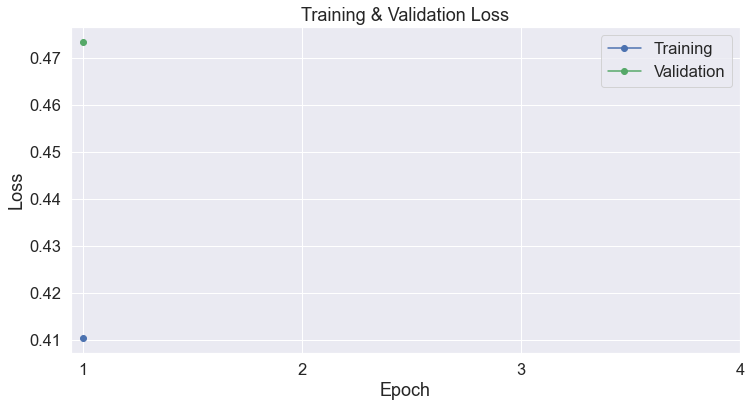

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(X_test):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length', 
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Create the DataLoader.
# prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 96,996 test sentences...



    DONE.


In [ ]:
print(len(X_test), len(predictions))

96996 12125


In [ ]:
pred = np.array([])
for el in predictions:
  pred = np.append(pred, el[:,1], axis=0)

len(pred)

96996

In [ ]:
pred[:100]

array([-2.54413056,  1.48203063,  1.48203063,  1.48203063, -2.50749898,
        0.72748846,  1.48203063, -2.56993985,  1.48203063, -2.57356334,
       -2.57347083,  1.48203063,  1.48203063, -2.55104661, -2.57108235,
       -2.57215047,  1.48203063, -2.53483081, -2.39211774, -2.38202667,
       -2.53483081, -2.56914878, -1.57004035, -2.35421348, -2.38605905,
       -2.38605905, -2.57124257, -2.57333493,  0.53855199, -2.57100606,
        0.53855199, -2.5726006 , -2.57234621,  0.53855199, -2.5730505 ,
       -2.5723052 , -2.5643487 , -1.87705731, -2.56097007, -2.21519732,
       -0.94997227, -2.57289696, -1.88028145, -1.69606876, -0.94997227,
       -1.88028145, -1.37613451, -2.5715549 , -2.55786943,  1.49747467,
       -2.41765428, -2.56927919, -2.56775928, -2.57188392, -2.57389188,
       -2.39292574, -2.56224847, -1.93921006, -2.55776238, -2.55776238,
       -2.54382896, -2.56224847, -2.56724906, -2.56719565, -2.20831561,
       -2.56224847, -1.75298667, -2.57314539, -2.57292414, -2.54

In [ ]:
import pandas as pd
pd.Series(pred_edited).value_counts()

0    82601
1    14395
dtype: int64

In [ ]:
from  tqdm  import  tqdm 
import jsonlines
def save_output(data, path):
  res = []
  cnt  = 0
  with open('drive/MyDrive/rucos_test.jsonl', 'r', encoding='utf8') as json_file:
    json_list = list(json_file)

    for json_str in tqdm(json_list):
      max = -10
      item = json.loads(json_str)
      text = item['passage']['text']
      query = item['qas'][0]['query']
      ans = item['passage']['entities']
      for a in ans:
        if data[cnt]>=max:
          max=data[cnt]
          d={"idx": item["idx"],
             "text": item["passage"]["text"][a['start']:a['end']]
              }
        cnt+=1
      
      res.append(d)
     # print(a)
    with open(path, mode="w") as file:
      for line in sorted(res, key=lambda x: int(x.get("idx"))):
        line["idx"] = int(line["idx"])
        file.write(f"{json.dumps(line, ensure_ascii=False)}\n")
                

In [ ]:
save_output(pred, 'submission.jsonl')